In [60]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [61]:
import matplotlib.pyplot as plt

# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 12.0]

In [62]:
import pandas as pd
import numpy as np

In [63]:
from pandas_summary import DataFrameSummary

In [110]:
# import my Finance Analysis Tools (fat)
import finance as fat

In [65]:
# full imports of fastai fail on windows, so just import some of it for now
from fastai.structured import add_datepart, apply_cats, proc_df

<b>Don't run this on windows, only on paperspace...

In [ ]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [66]:
TICKER = 'IAU'
PATH = f'data/{TICKER}-test'

## Load basic data

In [111]:
data = fat.create_dl_ticker_features(TICKER)

Loaded data for IAU: 2005-01-28 to 2018-02-21.


## Create Features

In [112]:
data = fat.create_dl_features(data)

We'll also add google trends for searches for  "gold price usd"

In [118]:
search = "gold price usd"
trends = fat.get_google_trends_df(data, search)

In [ ]:
trends.tail()

In [119]:
data = pd.DataFrame.join(data, trends)

In [120]:
data = data.dropna()
data[-14:]

,Open,High,Low,Close,Adj Close,Volume,Daily Range,Daily Gain,Close Higher than Open,Close Lower than Open,...,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Will Close Higher Tomorrow,gold price usd,Days since updated gold price usd
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-12,12.76,12.87,12.73,12.86,12.86,13305400,0.14,0.10,True,False,...,False,False,False,False,False,False,1515715200,False,83.0,11.0
2018-01-16,12.82,12.87,12.79,12.86,12.86,7295900,0.08,0.04,True,False,...,False,False,False,False,False,False,1516060800,False,83.0,15.0
2018-01-17,12.84,12.88,12.74,12.77,12.77,22220900,0.14,-0.07,False,True,...,False,False,False,False,False,False,1516147200,False,83.0,16.0
2018-01-18,12.79,12.80,12.73,12.75,12.75,18560300,0.07,-0.04,False,True,...,False,False,False,False,False,False,1516233600,True,83.0,17.0
2018-01-19,12.80,12.83,12.78,12.78,12.78,6918900,0.05,-0.02,False,True,...,False,False,False,False,False,False,1516320000,True,83.0,18.0
2018-01-22,12.81,12.83,12.78,12.81,12.81,6715900,0.05,0.00,False,False,...,False,False,False,False,False,False,1516579200,True,83.0,21.0
2018-01-23,12.81,12.89,12.78,12.88,12.88,11162200,0.11,0.07,True,False,...,False,False,False,False,False,False,1516665600,True,83.0,22.0
2018-01-24,13.00,13.08,12.98,13.05,13.05,15587600,0.10,0.05,True,False,...,False,False,False,False,False,False,1516752000,False,83.0,23.0
2018-01-25,13.03,13.11,12.89,12.94,12.94,19944800,0.22,-0.09,False,True,...,False,False,False,False,False,False,1516838400,True,83.0,24.0


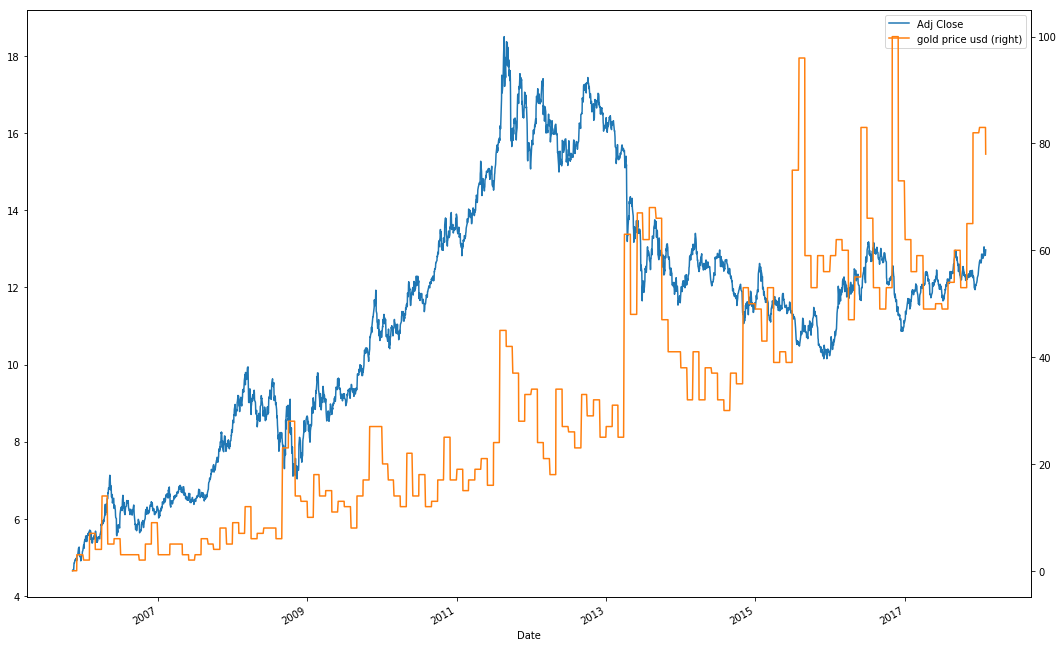

In [121]:
plot_data = data[['Adj Close', search]]
plot_data.plot(secondary_y = [search])

We're going to try to be predicting whether price will close higher tomorrow, so add a column with that info.

In [122]:
data['Will Close Higher Tomorrow'] = data['Closed Higher than Prev Close'].shift(-1)

In [125]:
data = data.dropna()

In [126]:
DataFrameSummary(data).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Open,3076,11.2749,3.13942,4.659,8.9935,11.7765,12.9,18.51,3076,1608,0,0%,numeric
High,3076,11.3343,3.15005,4.68,9.07325,11.82,12.96,18.63,3076,1625,0,0%,numeric
Low,3076,11.2093,3.12723,4.644,8.93,11.72,12.8425,18.25,3076,1632,0,0%,numeric
Close,3076,11.2743,3.13954,4.653,9.00975,11.77,12.89,18.5,3076,1633,0,0%,numeric
Adj Close,3076,11.2743,3.13954,4.653,9.00975,11.77,12.89,18.5,3076,1633,0,0%,numeric
Volume,3076,4.96384e+06,4.58622e+06,135000,2.11215e+06,3.8345e+06,6.34968e+06,6.99811e+07,3076,2905,0,0%,numeric
Daily Range,3076,0.124948,0.0875506,0.02,0.07,0.1,0.15,1.04,3076,692,0,0%,numeric
Daily Gain,3076,-0.00062874,0.0919416,-0.890001,-0.04,0,0.04,0.838,3076,808,0,0%,numeric
Close Higher than Open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3076,2,0,0%,bool
Close Lower than Open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3076,2,0,0%,bool


In [127]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily Range',
       'Daily Gain', 'Close Higher than Open', 'Close Lower than Open',
       'High was Open', 'High was Close', 'Low was Open', 'Low was Close',
       'Closed Higher than Prev Close', 'Closed Lower than Prev Close',
       'Adj Close SMA3', 'Adj Close SMA5', 'Adj Close SMA10',
       'Adj Close SMA20', 'Adj Close SMA50', 'Adj Close SMA100',
       'Adj Close SMA200', 'pct diff Adj Close SMA3',
       'pct diff Adj Close SMA5', 'pct diff Adj Close SMA10',
       'pct diff Adj Close SMA20', 'pct diff Adj Close SMA50',
       'pct diff Adj Close SMA100', 'pct diff Adj Close SMA200', 'Volume SMA3',
       'Volume SMA5', 'Volume SMA10', 'Volume SMA20', 'Volume SMA50',
       'Volume SMA100', 'Volume SMA200', 'pct diff Volume SMA3',
       'pct diff Volume SMA5', 'pct diff Volume SMA10',
       'pct diff Volume SMA20', 'pct diff Volume SMA50',
       'pct diff Volume SMA100', 'pct diff Volume SMA200',
       'Day

Break the columns up into "category variables" and "continuous variables".

In [134]:
cat_vars = ['Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days since updated gold price usd',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
            'Close Higher than Open', 'Close Lower than Open', 'High was Open', 'High was Close', 'Low was Open', 
            'Low was Close', 'Closed Higher than Prev Close', 'Closed Lower than Prev Close', 'Days Since Trading', 
            'Days Until Trading']

contin_vars = ['Year', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily Range',
               'Daily Gain','gold price usd', 'Elapsed',
               'Adj Close SMA3', 'Adj Close SMA5', 'Adj Close SMA10', 'Adj Close SMA20', 'Adj Close SMA50', 
               'Adj Close SMA100', 'Adj Close SMA200',
               'pct diff Adj Close SMA3', 'pct diff Adj Close SMA5', 'pct diff Adj Close SMA10', 'pct diff Adj Close SMA20', 
               'pct diff Adj Close SMA50', 'pct diff Adj Close SMA100', 'pct diff Adj Close SMA200', 'Volume SMA3', 
               'Volume SMA5', 'Volume SMA10', 'Volume SMA20', 'Volume SMA50', 'Volume SMA100', 'Volume SMA200', 
               'pct diff Volume SMA3', 'pct diff Volume SMA5', 'pct diff Volume SMA10', 'pct diff Volume SMA20', 
               'pct diff Volume SMA50', 'pct diff Volume SMA100', 'pct diff Volume SMA200']

In [135]:
print(f'len(cat_vars) = {len(cat_vars)}')
print(f'len(contin_vars) = {len(contin_vars)}')
print(f'len(data.columns) = {len(data.columns)}')
assert(len(data.columns) == (len(cat_vars) + len(contin_vars) + 1))

len(cat_vars) = 22
len(contin_vars) = 39
len(data.columns) = 62


Split data into train and test sets.

In [ ]:
data_len = len(data)
train_len = int(data_len * .8)
data_train = data[:train_len].copy()
data_test = data[train_len:].copy()

In [ ]:
dep = 'Tomorrow Adj Close'
data_train = data_train.reset_index()
data_train = data_train[cat_vars+contin_vars+[dep, 'Date']].copy()

In [ ]:
data_train.tail().T

In [ ]:
data_test[dep] = 0
data_test = data_test.reset_index()
data_test = data_test[cat_vars+contin_vars+[dep,'Date']].copy()

In [ ]:
data_test.head().T

In [ ]:
data_train = data_train.dropna()
data_test = data_test.dropna()

In [ ]:
for v in cat_vars: 
    data_train[v] = data_train[v].astype('category').cat.as_ordered()

In [ ]:
apply_cats(data_test, data_train)

In [ ]:
for v in contin_vars:
    data_train[v] = data_train[v].astype('float32')
    data_test[v] = data_test[v].astype('float32')

In [ ]:
DataFrameSummary(data_train).summary().T

We can now process our data...

In [ ]:
# we get a AttributeError here if we don't have skip_flds = ['Date']
data_train = data_train.set_index('Date')
df_train, y, nas, mapper = proc_df(data_train, dep, do_scale=True)
yl = np.log(y)

In [ ]:
df_train.head(2).T

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [ ]:
train_ratio = 0.75
data_size = len(df_train)
train_size = int(data_size * train_ratio)
val_idx = list(range(train_size, data_size))

In [ ]:
data_test = data_test.set_index('Date')
df_test, _, nas, mapper = proc_df(data_test, dep, do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [ ]:
#joined = joined.dropna()
#joined_test = joined_test.dropna()

## Deep Learning

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [ ]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [ ]:
# before: bs=128, changed to bs=8 to get results while finding learning rate
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_train, yl.astype(np.float32), cat_flds=cat_vars, bs=8,
                                       test_df=df_test)

Create categorical variables.

In [ ]:
cat_sz = [(c, len(data_train[c].cat.categories)+1) for c in cat_vars]
cat_sz

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [ ]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

Find learning rate.

In [ ]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [ ]:
m.lr_find(1e-7,1e-2)

In [ ]:
m.sched.plot(100)

### Sample

In [ ]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe])

In [ ]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

In [ ]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [ ]:
x,y=m.predict_with_targs()

In [ ]:
exp_rmspe(x,y)

In [ ]:
pred_test=m.predict(is_test=True)

In [ ]:
pred_test = np.exp(pred_test)

In [ ]:
data_test[dep]=pred_test

In [ ]:
# prediction are made for the next day ('Date'+1), so shift data so that date is proper date for value predicted 
predict = pd.DataFrame(data_test[dep].shift(1))
predict.columns = [f'Predicted {TICKER} Price']
predict[f'Actual {TICKER} Price'] = data['Adj Close']
predict.dropna()
predict['Prediction Error'] = predict[0] - predict[1]

In [ ]:
filename = f'{PATH}/{TICKER}-predictions-{dt.now():%Y%m%d-%H%M%S}.csv'
predict.to_csv(filename)

In [ ]:
predict.plot()

In [ ]:
rmse = np.sqrt(mean_squared_error(predict[0], predict[1]))
rmspe = rmse / len(predict)
#ex_rmspe = np.(rmspe)
print(f'RMSE = {rmse}')
print(f'RMSPE = {rmspe}')
#print(f'exp RMSPE = {ex_rmspe}')